# Problema de Negócio

A InStyle é uma das maiores lojas de roupas dos Estados Unidos que passa por problemas de customer experience ou experiência do cliente.

O grande desafio de escalar o faturamento de uma loja é manter a qualidade do produto e a taxa de satisfação do cliente em alta.

À medida que a empresa alcance mais clientes, os processos internos de vendas que começa com a concepção do produto, passam pela divulgação do marketing e chegam até os sistemas de pagamento do financeiro começam a apresentar problemas.

O time de produtos tem dificuldade em determinar a necessidade da maioria dos clientes. O time de marketing enfrente desafios para determinar o cliente ideal e o time de desenvolvimento sofre com os grandes volumes de acessos no site e em seu aplicativo, causando quedas de sistema e tornando o site inoperante por algumas horas, impedindo as pessoas de comprar e assim, gerando muitas reclamações no atendimento, liderado pelo time de customer experience.

Portanto, a medição da satisfação dos clientes é extremamente importante para a empresa manter a boa reputação no mercado.

Um time interdisciplinar chamado de “War Room”, formado por profissionais de Produto, Marketing, Design, Dados e Desenvolvimento foi montado para garantir uma ótima experiência de compra ao cliente e uma alta taxa de satisfação, mesmo com o crescimento rápido do volume de vendas.

Uma das primeiras ações emergenciais do War Room foi fazer um atendimento pessoal aos clientes. Porém, a dificuldade inicial era identificar quais clientes teriam um nível de satisfação “Satisfeito” ou “Neutro/Insatisfeito”, para que o time conseguisse entrar em contato somente com os clientes “Neutro/Insatisfeito”.

Os Cientistas de Dados do War Room ficaram com a tarefa de treinar um algoritmo para classificar os clientes de uma planilha em “Satisfeito” ou “Neutro/Insatisfeito”, prevendo quais clientes ficarão Insatisfeitos e portanto agindo rápido para entender o motivo da insatisfação e reverter o cenário do cliente.

# Dados

**Arquivos**

* _treino.csv_ - base de dados de treino.<br>
* _teste.csv_ - base de dados de teste.<br>
* _submission.csv_ - um arquivo de submissão de exemplo no formato correto.

**Colunas**
* _Gender:_ Gênero do cliente<br>
* _Age:_ Idade do cliente<br>
* _Type of Purchase:_ O tipo de compra<br>
* _Store size:_ O tamanho da loja<br>
* _Store distance:_ Distância até o centro da cidade<br>
* _InStore wifi:_ Nível de satisfação com o Wifi da Loja<br>
* _Open/Close time convenient:_ Nível de satisfação do horário de abertura e fechamento da loja<br>
* _Easy of online shopping:_ Nível de satisfação com a compra online<br>
* _Store location:_ Nível de satisfação com a acesso a loja<br>
* _Toilet cleaning:_ Nível de limpeza dos banheiros<br>
* _Dressing room:_ Nível de satisfação com o provador<br>
* _Waiting room:_ Nível de satisfação do local de espera dentro da loja.<br>
* _Kids entertainment:_ Nível de satisfação do espaço kids<br>
* _Seller service:_ Nível de satisfação com o atendimento dos vendedores<br>
* _Showroom:_ Nível de satisfação com a disposição das roupas no interior da loja<br>
* _Self-Store:_ Nível de satisfação com os guarda-volumes da loja<br>
* _Purchase service:_ Nível de satisfação do atendimento no pagamento<br>
* _Inflights Service:_ Store Service<br>
* _Cleanliness:_ Nível de satisfação com a limpeza da loja<br>
* _Carrier delay in minutes:_ Tempo de atraso do produto na saída da transportadora<br>
* _Delivery delay in minutes:_ Tempo de atraso na entrega do produto até a casa do cliente.

In [1]:
#!pip install lightgbm
#!pip install sweetviz

# Bibliotecas

In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sweetviz as sv
import time
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import average_precision_score

from sklearn.ensemble        import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing   import RobustScaler
from scipy import stats

# Configurações

In [3]:
pd.set_option('display.max_columns', None)

# Funções

In [4]:
# Renomeia colunas
def changecase(x):
    output=[]
    for i in x:
        i=i.title()
        i=i.strip().replace(' ', '').replace('-', '').replace('/', '')
        i=i[0].lower()+i[1:]
        i = i.replace('instoreWifi','inStoreWifi')        
        output.append(i)
    return output

# Extração de Dados

In [5]:
train_raw = pd.read_csv("train.csv")

In [6]:
test_raw = pd.read_csv("test.csv")

# Análise Exploratória dos Dados

In [7]:
df1 = train_raw.copy()

In [8]:
df1.head(5)

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,Store location,Toilet cleaning,Dressing room,Waiting room,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
0,70172,Male,Loyal Customer,13,Personal,Small,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,Neutral or Dissatisfaction
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,Neutral or Dissatisfaction
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,Satisfied
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,Neutral or Dissatisfaction
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,Satisfied


## Colunas

In [9]:
df1.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase',
       'Store size', 'Store distance', 'InStore wifi',
       'Open/Close time convenient', 'Easy of online shopping',
       'Store location', 'Toilet cleaning', 'Dressing room', 'Waiting room',
       'Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store',
       'Purchase service', 'Store Service', 'Cleanliness',
       'Carrier delay in minutes', 'Delivery delay in minutes',
       'Satisfaction'],
      dtype='object')

In [10]:
# Renomeia colunas
df1.columns = changecase(df1.columns)

In [11]:
# Tipo das colunas
df1.dtypes

id                           int64
gender                      object
customerType                object
age                          int64
typeOfPurchase              object
storeSize                   object
storeDistance                int64
inStoreWifi                  int64
openCloseTimeConvenient      int64
easyOfOnlineShopping         int64
storeLocation                int64
toiletCleaning               int64
dressingRoom                 int64
waitingRoom                  int64
kidsEntertainment            int64
sellerService                int64
showroom                     int64
selfStore                    int64
purchaseService              int64
storeService                 int64
cleanliness                  int64
carrierDelayInMinutes        int64
deliveryDelayInMinutes     float64
satisfaction                object
dtype: object

## Descrição Estatística

In [12]:
describe = df1.describe().T
describe

,count,mean,std,min,25%,50%,75%,max
id,103904.0,64924.210502,37463.812252,1.0,32533.75,64856.5,97368.25,129880.0
age,103904.0,39.379706,15.114964,7.0,27.00,40.0,51.00,85.0
storeDistance,103904.0,1189.448375,997.147281,31.0,414.00,843.0,1743.00,4983.0
inStoreWifi,103904.0,2.729683,1.327829,0.0,2.00,3.0,4.00,5.0
openCloseTimeConvenient,103904.0,3.060296,1.525075,0.0,2.00,3.0,4.00,5.0
easyOfOnlineShopping,103904.0,2.756901,1.398929,0.0,2.00,3.0,4.00,5.0
storeLocation,103904.0,2.976883,1.277621,0.0,2.00,3.0,4.00,5.0
toiletCleaning,103904.0,3.202129,1.329533,0.0,2.00,3.0,4.00,5.0
dressingRoom,103904.0,3.250375,1.349509,0.0,2.00,3.0,4.00,5.0
waitingRoom,103904.0,3.439396,1.319088,0.0,2.00,4.0,5.00,5.0


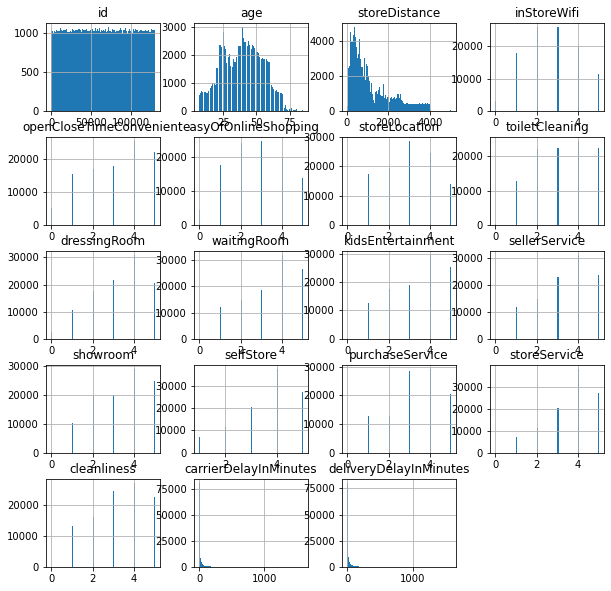

In [13]:
plt.rcParams['figure.figsize'] = [10,10]
num_attributes = df1.select_dtypes( include= ['float64', 'int64'] )
num_attributes.hist( bins= 100);

## Valores únicos em "satisfaction"

In [14]:
df1['satisfaction'].unique()

array(['Neutral or Dissatisfaction', 'Satisfied'], dtype=object)

In [15]:
# Substitui valores do target por boolean para serem interpretados pelo sweetviz
sv_df = df1.copy()
sv_df['satisfaction'] = sv_df['satisfaction'].apply(lambda x: 1 if x == 'Satisfied' else 0)
#report = sv.analyze(source = sv_df, target_feat = 'satisfaction')

#report.show_notebook(w="100%", h="full")

## Tamanho dos Dados

In [16]:
print("Linhas:",df1.shape[0])
print("Colunas:",df1.shape[1])

Linhas: 103904
Colunas: 24


## Número de Duplicados

In [17]:
len(df1[df1.duplicated()].index)

0

## Número de NAs

In [18]:
df1.isna().sum()

id                           0
gender                       0
customerType                 0
age                          0
typeOfPurchase               0
storeSize                    0
storeDistance                0
inStoreWifi                  0
openCloseTimeConvenient      0
easyOfOnlineShopping         0
storeLocation                0
toiletCleaning               0
dressingRoom                 0
waitingRoom                  0
kidsEntertainment            0
sellerService                0
showroom                     0
selfStore                    0
purchaseService              0
storeService                 0
cleanliness                  0
carrierDelayInMinutes        0
deliveryDelayInMinutes     310
satisfaction                 0
dtype: int64

## Correlação

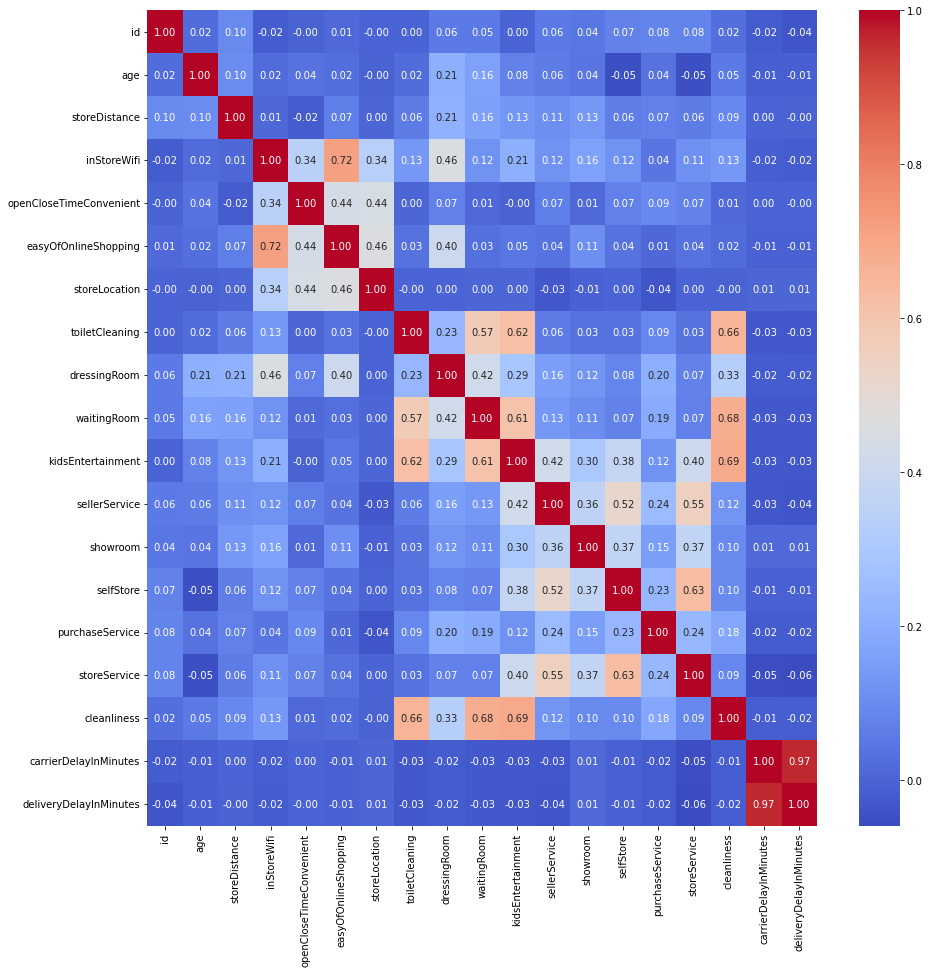

In [19]:
plt.rcParams['figure.figsize'] = [15,15]

# Calcular a matriz de correlação
correlation_matrix = df1.corr()

# Gerar o mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f');

# Preparação dos Dados

In [20]:
df2 = df1.copy()

## Transformação

In [21]:
# Substitui valores nulos
df2 = df2.fillna(-1)
df2['deliveryDelayInMinutes'] = df2['deliveryDelayInMinutes'].astype('int64')

In [22]:
# Lista valores únicos das variáveis categóricas
for i in df2.select_dtypes(include='object').columns:
    print(i,"-",df2[i].unique())

gender - ['Male' 'Female']
customerType - ['Loyal Customer' 'disloyal Customer']
typeOfPurchase - ['Personal' 'Gift']
storeSize - ['Small' 'Large' 'Medium']
satisfaction - ['Neutral or Dissatisfaction' 'Satisfied']


In [23]:
df2.rename(columns={'customerType':'customerIsLoyal',
                    'typeOfPurchase':'isGift'},inplace=True)

In [24]:
# Boolean
df2['satisfaction'] = df2['satisfaction'].apply(lambda x: 1 if x == 'Satisfied' else 0)
df2['customerIsLoyal'] = df2['customerIsLoyal'].apply(lambda x: 1 if x == 'Loyal Customer' else 0)
df2['isGift'] = df2['isGift'].apply(lambda x: 1 if x == 'Gift' else 0)

# Ordinal Encoding
size_dict = {'Small':1, 'Medium':2, 'Large':3}
df2['storeSize'] = df2['storeSize'].map(size_dict)

# Get dummies
df2 = pd.get_dummies(df2)

## Reescala

In [25]:
rs = RobustScaler()

# age - Robust Scaler
df2['age'] = rs.fit_transform( df2[['age']].values )

# storeDistance - Robust Scaler
df2['storeDistance'] = rs.fit_transform( df2[['storeDistance']].values )

# carrierDelayInMinutes - Robust Scaler
df2['carrierDelayInMinutes'] = rs.fit_transform( df2[['carrierDelayInMinutes']].values )

# deliveryDelayInMinutes - Robust Scaler
df2['deliveryDelayInMinutes'] = rs.fit_transform( df2[['deliveryDelayInMinutes']].values )

# Feature Engineering

In [26]:
# Remove colunas para simplificar o modelo:
remover_colunas = ['toiletCleaning', 'openCloseTimeConvenient',
                   'deliveryDelayInMinutes', 'carrierDelayInMinutes']

In [27]:
df3 = df2.drop(columns=remover_colunas)

# Modelos Machine Learning

In [28]:
# Separa 30% da base para validação
validacao = df3.sample(int(0.3*df3.shape[0]),random_state=0)
df4 = df3.iloc[~df3.index.isin(validacao.index)]

In [29]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df4.drop(columns=['satisfaction']),
                                                    df4[['satisfaction']],
                                                    test_size=0.30,
                                                    random_state=0)
y_train = y_train['satisfaction'].values

## Random Forest

In [30]:
# model definition
rf_model = RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state= 42)

# model training
rf_model.fit(X_train, y_train);

In [31]:
# Performance
# Teste
y_pred_rf = rf_model.predict(X_test)
avg_score_rf = average_precision_score(y_test, y_pred_rf, average= 'micro')
print( f'Avg Precision Score - Teste - Random Forest: {avg_score_rf:.2%}' )

# Validação
y_pred_val_rf = rf_model.predict(validacao.drop(columns=['satisfaction']))
avg_score_rf = average_precision_score(validacao[['satisfaction']], y_pred_val_rf, average= 'micro')
print( f'Avg Precision Score - Validação - Random Forest: {avg_score_rf:.2%}' )

Avg Precision Score - Teste - Random Forest: 94.24%
Avg Precision Score - Validação - Random Forest: 94.17%


## XGBoost

In [32]:
# model definition
xgb_model = GradientBoostingClassifier()

# Fit
xgb_model.fit( X_train, y_train );

In [33]:
# Performance
# Teste
y_pred_xgb = xgb_model.predict(X_test)
avg_score_xgb = average_precision_score(y_test, y_pred_xgb, average= 'micro')
print( f'Avg Precision Score - Teste - XGB: {avg_score_xgb:.2%}' )

# Validação
y_pred_val_xgb = xgb_model.predict(validacao.drop(columns=['satisfaction']))
avg_score_xgb = average_precision_score(validacao[['satisfaction']], y_pred_val_xgb, average= 'micro')
print( f'Avg Precision Score - Validação - XGB: {avg_score_xgb:.2%}' )

Avg Precision Score - Teste - XGB: 90.78%
Avg Precision Score - Validação - XGB: 90.62%


## LGBM

In [34]:
lgbm_model = lgb.LGBMClassifier(verbose=-1, random_state = 0)

# model training
lgbm_model.fit(X_train, y_train);

In [35]:
# Performance
# Teste
y_pred_lgbm = lgbm_model.predict(X_test)
avg_score_lgbm = average_precision_score(y_test, y_pred_lgbm, average= 'micro')
print( f'Avg Precision Score - Teste - LGBM: {avg_score_lgbm:.2%}' )

# Validação
y_pred_val_lgbm = lgbm_model.predict(validacao.drop(columns=['satisfaction']))
avg_score_lgbm = average_precision_score(validacao[['satisfaction']], y_pred_val_lgbm, average= 'micro')
print( f'Avg Precision Score - Validação - LGBM: {avg_score_lgbm:.2%}' )

Avg Precision Score - Teste - LGBM: 94.29%
Avg Precision Score - Validação - LGBM: 94.38%


# Fine Tuning do Modelo LGBM

In [36]:
t_start = time.time()
print('Start:',datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),'\n')

# Define the LightGBM classifier
lgb_clf = lgb.LGBMClassifier(random_state=42,verbose=-1)

# Define the parameter grid for the RandomizedSearchCV
param_grid = {
    'n_estimators': stats.randint(100, 2000),
    'max_depth': stats.randint(3, 20),
    'learning_rate': [0.01, 0.05, 0.1, 1],
    'num_leaves': stats.randint(20, 200),
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0, 1.5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0, 1.5]
}

# Define the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_grid,
    n_iter=100,
    scoring='average_precision',
    cv=5,
    random_state=42,
    verbose=0
)

# Run the parameter search
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", random_search.best_params_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
avg_precision = best_model.score(X_test, y_test)
print( f'Avg Precision LGBM: {avg_precision:.2%}' )

duration = time.time()-t_start
h = '{:02d}'.format(int(duration//3600))
m = '{:02d}'.format(int((duration%3600)//60))
s = '{:02d}'.format(int(duration%60))

print('\nEnd:',datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
print(f'Fine tuning execution time: {h}:{m}:{s}')

Start: 23-07-2023 23:07:14 



C:\Users\julia\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\julia\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\julia\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 1142, in fit
    super().fit(
  File "C:\Users\julia\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 842, in fit
    self._Booster = train(
  File "C:\Users\julia\anaconda3\lib\site-packages\lightgbm\engine.py", line 245, i

Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 17, 'n_estimators': 1230, 'num_leaves': 91, 'subsample': 1.0}
Avg Precision LGBM: 96.54%

End: 24-07-2023 00:02:51
Fine tuning execution time: 00:55:36


# Aplicação do Modelo

## Separação de treino e teste

In [37]:
test = test_raw.copy()
train = train_raw.copy()
submission = test[['id']]

In [38]:
X_train = train.drop(columns = ['Satisfaction'])
y_train = train['Satisfaction'].apply(lambda x: 1 if x == 'Satisfied' else 0)

## Transformação e Reescala

In [39]:
def transforma_df(df,remover=[]):
    
    # Renomeia colunas
    df.columns = changecase(df.columns)
    
    # Substitui valores nulos
    df = df.fillna(-1)
    df['deliveryDelayInMinutes'] = df['deliveryDelayInMinutes'].astype('int64')
    
    df.rename(columns={'customerType':'customerIsLoyal',
                     'typeOfPurchase':'isGift'},inplace=True)
    
    # Boolean
    df['customerIsLoyal'] = df['customerIsLoyal'].apply(lambda x: 1 if x == 'Loyal Customer' else 0)
    df['isGift'] = df['isGift'].apply(lambda x: 1 if x == 'Gift' else 0)
    
    # Ordinal Encoding
    size_dict = {'Small':1, 'Medium':2, 'Large':3}
    df['storeSize'] = df['storeSize'].map(size_dict)
    
    # Get dummies
    df = pd.get_dummies(df)
    
    df.drop(columns=remover,inplace=True)
    
    return df

# Colunas a serem removidas
remover = ['toiletCleaning', 'openCloseTimeConvenient', 'deliveryDelayInMinutes', 'carrierDelayInMinutes']

# Transforma dados da base de treino e teste
test =  transforma_df(test,remover)
X_train = transforma_df(X_train,remover)

## Treino e Predição

In [40]:
# Model
lgbm_model = lgb.LGBMClassifier(colsample_bytree = 0.9,
                                learning_rate = 0.01,
                                max_depth = 17,
                                n_estimators = 1230,
                                num_leaves = 91,
                                subsample = 1.0,
                                verbose=-1,
                                random_state = 0)


# model training
lgbm_model.fit(X_train, y_train)

# predict
y_pred_test_rf = lgbm_model.predict(test)

submission['Satisfaction'] = y_pred_test_rf
submission.to_csv('submission.csv',index=False)

In [41]:
submission

,id,Satisfaction
0,19556,1
1,90035,1
2,12360,0
3,77959,1
4,36875,0
...,...,...
25971,78463,0
25972,71167,1
25973,37675,0
25974,90086,1
